In [14]:
from diff_predictor import data_process, predxgboost, spatial
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from os import listdir, getcwd, chdir
from os.path import isfile, join
import os
from sklearn.preprocessing import scale, StandardScaler
from numpy.random import permutation


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, recall_score, precision_score, f1_score
import operator
import xgboost as xgb
import shap
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException
from xgboost.core import STRING_TYPES

from sklearn.decomposition import PCA

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline


In [2]:
workbookDir = getcwd()

print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
chdir('..')
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/rotenone_notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/nancelab/diff_predictor


In [3]:
#load paths to data
cortex_10day_feature_path = workbookDir + '/data/Brendan_traj_data/Cortex_features/'
cortex_10day_feature_filelist = [f for f in listdir(cortex_10day_feature_path) if isfile(join(cortex_10day_feature_path, f)) and '10DIV' in f]
print(len(cortex_10day_feature_filelist))
print()
cortex_7day_feature_path = workbookDir + '/data/Brendan_traj_data/Cortex_features/'
cortex_7day_feature_filelist = [f for f in listdir(cortex_7day_feature_path) if isfile(join(cortex_7day_feature_path, f)) and '7DIV' in f]
print((len(cortex_7day_feature_filelist)))

8

8


In [4]:
fstats_cortex_10day = data_process.generate_fullstats(cortex_10day_feature_path, cortex_10day_feature_filelist, ['10uM', '5uM', '1uM', 'NT'], 'dosage')
fstats_cortex_7day = data_process.generate_fullstats(cortex_7day_feature_path, cortex_7day_feature_filelist, ['NT', '50nM', '1uM', '5uM'], 'dosage')

Adding file features_P10F_10uM_10DIV_40nm_slice_2_cortex_vid_1.csv size: (2460, 68)
Adding file features_P10F_NT_10DIV_40nm_slice_1_cortex_vid_2.csv size: (1351, 68)
Adding file features_P10F_NT_10DIV_40nm_slice_1_cortex_vid_1.csv size: (1533, 68)
Adding file features_P10F_NT_10DIV_40nm_slice_2_cortex_vid_2.csv size: (971, 68)
Adding file features_P10F_1uM_10DIV_40nm_slice_1_cortex_vid_1.csv size: (2418, 68)
Adding file features_P10F_5uM_10DIV_40nm_slice_1_cortex_vid_2.csv size: (1481, 68)
Adding file features_P10F_10uM_10DIV_40nm_slice_1_cortex_vid_1.csv size: (957, 68)
Adding file features_P10F_5uM_7DIV_40nm_slice_1_cortex_vid_1.csv size: (2405, 68)
Adding file features_P10F_NT_7DIV_40nm_slice_1_cortex_vid_1.csv size: (1738, 68)
Adding file features_P10F_NT_7DIV_40nm_slice_1_cortex_vid_2.csv size: (1190, 68)
Adding file features_P10F_1uM_7DIV_40nm_slice_1_cortex_vid_1.csv size: (638, 68)
Adding file features_P10F_50nM_7DIV_40nm_slice_1_cortex_vid_2.csv size: (1785, 68)
Adding file fe

In [5]:
feature_list = [
#     'alpha', # Fitted anomalous diffusion alpha exponenet
#     'D_fit', # Fitted anomalous diffusion coefficient
#     'kurtosis', # Kurtosis of track
#     'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
#     'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
#     'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
#     'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
#     'elongation', # Est. of amount of extension of trajectory from centroid
#     'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
#     'fractal_dim', # Measure of how complicated a self similar figure is
#     'trappedness', # Probability that a particle with Deff is trapped in a region
#     'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
#     'straightness', # Ratio of net displacement to the sum of squared step lengths
#     'MSD_ratio', # MSD ratio of the track
# #     'frames', # Number of frames the track spans
#     'Deff1', # Effective diffusion coefficient at 0.33 s
#     'Deff2', # Effective diffusion coefficient at 3.3 s
    # 'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    # 'angle_mag_mean', # Magnitude of the turning angle mean
    # 'angle_var', # Variance of the turning angle
    # 'dist_tot', # Total distance of the trajectory
    # 'dist_net', # Net distance from first point to last point
    # 'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'dosage'

In [8]:
fstats_cortex_10day


,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,...,Std SN_Ratio,Mean Deff1,Std Deff1,Mean Deff2,Std Deff2,dosage,Filename,Video Number,Log Deff1,Log10 Deff
0,0,1.174434e+00,0.000892,2.361415,0.826105,0.218454,0.230310,1.480340,0.324479,0.038134,...,0.144638,2.249462,1.515251,0.174454,0.146697,10uM,features_P10F_10uM_10DIV_40nm_slice_2_cortex_v...,0,NaN,NaN
1,1,2.160027e+00,0.019319,2.601975,0.961369,0.099241,0.409079,3.426703,0.708174,0.014796,...,0.160167,2.067819,0.903321,NaN,NaN,10uM,features_P10F_10uM_10DIV_40nm_slice_2_cortex_v...,0,NaN,NaN
2,2,3.246679e-01,9.244218,3.848979,0.660625,0.321361,0.141435,1.596040,0.373449,0.047237,...,0.113275,3.474980,3.926773,NaN,NaN,10uM,features_P10F_10uM_10DIV_40nm_slice_2_cortex_v...,0,NaN,NaN
3,3,5.121814e-01,31.590133,3.294442,0.717262,0.287903,0.165884,1.257176,0.204566,0.025260,...,0.203370,8.871918,4.828271,NaN,NaN,10uM,features_P10F_10uM_10DIV_40nm_slice_2_cortex_v...,0,NaN,NaN
4,4,2.467826e+00,0.123825,2.632196,0.975922,0.078059,0.455189,3.555683,0.718760,0.038261,...,0.107748,4.292129,1.877362,NaN,NaN,10uM,features_P10F_10uM_10DIV_40nm_slice_2_cortex_v...,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11166,952,1.760000e-07,25.266700,2.316257,0.883003,0.176343,0.281209,2.523485,0.603723,0.185547,...,0.029589,13.095274,15.374969,NaN,NaN,10uM,features_P10F_10uM_10DIV_40nm_slice_1_cortex_v...,6,-3.719026,NaN
11167,953,2.562699e+00,0.298926,2.634889,0.986393,0.058524,0.503414,4.285142,0.766635,0.054367,...,0.073531,26.267841,14.030791,NaN,NaN,10uM,features_P10F_10uM_10DIV_40nm_slice_1_cortex_v...,6,-2.849705,NaN
11168,954,1.730035e+00,1.813268,2.490807,0.933882,0.130765,0.350211,2.860159,0.650369,0.037136,...,0.088174,17.491939,11.775102,NaN,NaN,10uM,features_P10F_10uM_10DIV_40nm_slice_1_cortex_v...,6,-2.840511,NaN
11169,955,1.120000e-07,36.765647,2.025233,0.680853,0.309528,0.149668,1.869284,0.465036,0.265270,...,0.029589,13.095274,15.374969,NaN,NaN,10uM,features_P10F_10uM_10DIV_40nm_slice_1_cortex_v...,6,-3.544432,NaN


In [6]:
ecm_10day = fstats_cortex_10day[feature_list + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm_10day.shape)
ecm_10day = ecm_10day[~ecm_10day[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
print(ecm_10day.shape)
print()
ecm_7day = fstats_cortex_7day[feature_list + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm_7day.shape)
ecm_7day = ecm_7day[~ecm_7day[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
print(ecm_7day.shape)

(11171, 20)
(10446, 20)

(14080, 20)
(12585, 20)


In [7]:
ecm_10day = ecm_10day.drop(['X', 'Y', 'Track_ID'], axis=1)
labels_10day = np.array(ecm_10day['dosage'])
features_df_10day = ecm_10day.drop('dosage', axis=1)

#features_df_10day = 
col_names = features_df_10day.columns

labels_7day = np.array(ecm_7day['dosage'])
features_df_7day = ecm_7day.drop(['dosage', 'X', 'Y', 'Track_ID'], axis=1)
col_names = features_df_7day.columns

In [8]:
print(len(features_df_10day))
print(len(features_df_10day.drop_duplicates()))

10446
1429


In [20]:
scaler = StandardScaler()
scaled_df_10day = scaler.fit_transform(features_df_10day)
scaled_df_10day = pd.DataFrame(scaled_df_10day, columns=col_names)
scaled_df_10day = scaled_df_10day.fillna(0)

In [32]:
scaler = StandardScaler()
scaled_df_7day = scaler.fit_transform(features_df_7day)
scaled_df_7day = pd.DataFrame(scaled_df_7day, columns=col_names)
scaled_df_7day = scaled_df_7day.fillna(0)

In [21]:
pca = PCA(n_components=10).fit(scaled_df_10day)
print(pca.explained_variance_ratio_.sum())
pca_embeddings = pca.transform(scaled_df_10day)
pca_embeddings_df = pd.DataFrame(pca_embeddings[:, :2], columns=['Component 1', 'Component 2'])
pca_embeddings_df['target'] = labels_10day

0.9667246440170457


(array([-15., -10.,  -5.,   0.,   5.,  10.,  15.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

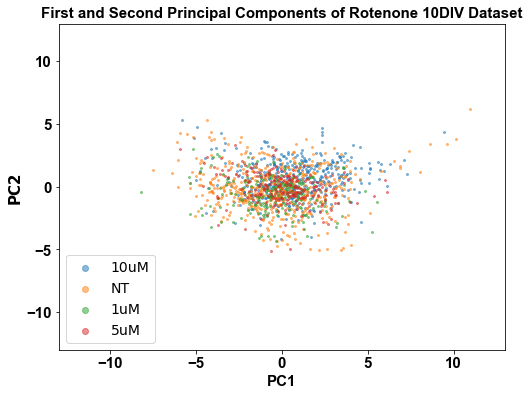

In [23]:
#colors = {'NT': '#56B4E9', '10uM': '#009E73'}# :'P14': '#E69F00', 'P21': '#7b3294', 'P28': '#d7191c'}

fig, ax = plt.subplots(figsize=(8,6))
for uclass in pca_embeddings_df['target'].unique():
    df = pca_embeddings_df[pca_embeddings_df['target'] == uclass]
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.5, s=4, label=uclass)#, c=colors[uclass])
plt.legend(loc='lower left', markerscale=3, fontsize=14)
plt.xlim([-13,13])
plt.ylim([-13,13])
plt.xlabel('PC1', fontname='Arial', fontsize=15, fontweight='bold')
plt.ylabel('PC2', fontsize=15, fontweight='bold')
plt.title('First and Second Principal Components of Rotenone 10DIV Dataset', fontname='Arial', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontname='Arial', fontweight='bold')
plt.yticks(fontsize=15, fontname='Arial', fontweight='bold')

In [17]:
pca = PCA(n_components=10).fit(scaled_df_7day)
print(pca.explained_variance_ratio_.sum())
pca_embeddings = pca.transform(scaled_df_7day)
pca_embeddings_df = pd.DataFrame(pca_embeddings[:, :2], columns=['Component 1', 'Component 2'])
pca_embeddings_df['target'] = labels_7day

0.8255143629562198


(array([-15., -10.,  -5.,   0.,   5.,  10.,  15.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

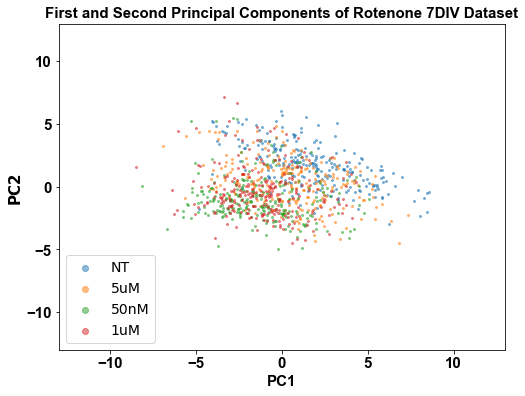

In [18]:
##colors = {'NT': '#56B4E9', '10uM': '#009E73'}# :'P14': '#E69F00', 'P21': '#7b3294', 'P28': '#d7191c'}

fig, ax = plt.subplots(figsize=(8,6))
for uclass in pca_embeddings_df['target'].unique():
    df = pca_embeddings_df[pca_embeddings_df['target'] == uclass].sample(250)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.5, s=4, label=uclass)#, #c=colors[uclass])
plt.legend(loc='lower left', markerscale=3, fontsize=14)
plt.xlim([-13,13])
plt.ylim([-13,13])
plt.xlabel('PC1', fontname='Arial', fontsize=15, fontweight='bold')
plt.ylabel('PC2', fontsize=15, fontweight='bold')
plt.title('First and Second Principal Components of Rotenone 7DIV Dataset', fontname='Arial', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontname='Arial', fontweight='bold')
plt.yticks(fontsize=15, fontname='Arial', fontweight='bold')

In [9]:
def full_preprocess(ecm, balanced=True, y_scramble=False, target=None):

    rand_state = np.random.randint(1, 2000)
    if balanced:
        bal_ecm = data_process.balance_data(ecm, target, random_state=rand_state)
        bal_ecm = bal_ecm.reset_index(drop=True)
        #sampled_df = bal_ecm.sample(frac=0.5)
        sampled_df = data_process.bin_data(bal_ecm)
    else:
        sampled_df = data_process.bin_data(ecm)
    #label_df = sampled_df[target]
    #features_df = sampled_df.drop([target, 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)
    features_df = sampled_df.drop([target, 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)
    features = features_df.columns

    if y_scramble:
        perm = permutation(len(label_df))
        label_shuffled = label_df[perm]
        le = preprocessing.LabelEncoder()
        sampled_df['encoded_target'] = le.fit_transform(label_shuffled)
    else:
        le = preprocessing.LabelEncoder()
        sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    seed = rand_state
    np.random.seed(seed)
    train_split = 0.8
    test_split = 0.5


    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    return dtrain, dtest, dval, X_train, X_test, y_train, y_test, le



In [10]:
param_10day = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 4,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
#          # GPU integration will cut time in ~half:
#          'gpu_id' : 0,
#          'tree_method': 'gpu_hist',
#          'predictor': 'gpu_predictor'
         }

In [11]:
param_7day = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 4,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
#          # GPU integration will cut time in ~half:
#          'gpu_id' : 0,
#          'tree_method': 'gpu_hist',
#          'predictor': 'gpu_predictor'
         }

In [28]:
def get_dropna_scores(ecm, target, param, boost_rounds=200):
    ecm = ecm.dropna()
    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm, True, False, target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=boost_rounds, verbose=False)
    return acc

In [29]:
def get_fillna_scores(ecm, target, param, boost_rounds=200, fillna_value=0):
    ecm = ecm.fillna(fillna_value)
    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm, True, False, target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=boost_rounds, verbose=False)
    print(f'accuracy is {acc}')
    return acc

In [30]:
def get_impute_knn_scores(ecm, target, param, boost_rounds):
    imputer = KNNImputer()
    impute_vals = imputer.fit_transform(ecm[feature_list])
    imputed_df = pd.DataFrame(data=impute_vals, columns=feature_list)
    imputed_df['dosage'] = ecm['dosage'].values
    imputed_df['X'] = ecm['X'].values
    imputed_df['Y'] = ecm['Y'].values
    imputed_df['Track_ID'] = ecm['Track_ID'].values 
    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(imputed_df, True, False, target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=boost_rounds, verbose=False)
    return acc

In [31]:
def get_impute_iterative_scores(ecm, target, param, boost_rounds):
    imputer = IterativeImputer()
    impute_vals = imputer.fit_transform(ecm[feature_list])
    imputed_df = pd.DataFrame(data=impute_vals, columns=feature_list)
    imputed_df['dosage'] = ecm['dosage'].values
    imputed_df['X'] = ecm['X'].values
    imputed_df['Y'] = ecm['Y'].values
    imputed_df['Track_ID'] = ecm['Track_ID'].values 
    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(imputed_df, True, False, target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=boost_rounds, verbose=False)
    return acc

In [10]:
ecm_10day[target].unique()

array(['50nM', '5uM', '1uM', '10uM', 'NT'], dtype=object)

In [15]:
test_output[target] = ecm_10day[target].replace({'50nM': 'rot', '5uM': 'rot', '1uM': 'rot' , '10uM': 'rot', 'NT': 'NC'})
test_output['dosage'].unique()

array(['rot', 'NC'], dtype=object)

In [22]:
ecm_10day[target] = ecm_10day[target].replace({'50nM': 'rot', '5uM': 'rot', '1uM': 'rot' , '10uM': 'rot', 'NT': 'NC'})


num_iters = 25

normal_acc = np.zeros(num_iters)
# fillna_acc = np.zeros(num_iters)
# dropna_acc = np.zeros(num_iters)
# impute_knn_acc= np.zeros(num_iters)
# impute_iterative_acc = np.zeros(num_iters)

for i in range(num_iters):
    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm_10day, True, False, target)
    booster, acc, true_label, preds = predxgboost.train(param_10day, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    normal_acc[i] = acc
    # fillna_acc[i] = get_fillna_scores(ecm_10day, 'dosage', param_10day, 1000, 0)
    # dropna_acc[i] = get_dropna_scores(ecm_10day, 'dosage', param_10day, 200)
    # impute_knn_acc[i] = get_impute_knn_scores(ecm_10day, 'dosage', param_10day, 1000)
    # impute_iterative_acc[i] = get_impute_iterative_scores(ecm_10day, 'dosage', param_10day, 200)

Ratio before data balance (rot:NC) = 10932:2960
Ratio after balance (rot:NC) = 2960:2960
Accuracy: 0.7983193277310925
Ratio before data balance (rot:NC) = 10932:2960
Ratio after balance (rot:NC) = 2960:2960
Accuracy: 0.8278985507246377
Ratio before data balance (rot:NC) = 10932:2960
Ratio after balance (rot:NC) = 2960:2960
Accuracy: 0.76875
Ratio before data balance (rot:NC) = 10932:2960
Ratio after balance (rot:NC) = 2960:2960
Accuracy: 0.738404452690167
Ratio before data balance (rot:NC) = 10932:2960
Ratio after balance (rot:NC) = 2960:2960
Accuracy: 0.8336380255941499
Ratio before data balance (rot:NC) = 10932:2960
Ratio after balance (rot:NC) = 2960:2960
Accuracy: 0.8174442190669371
Ratio before data balance (rot:NC) = 10932:2960
Ratio after balance (rot:NC) = 2960:2960
Accuracy: 0.769090909090909
Ratio before data balance (rot:NC) = 10932:2960
Ratio after balance (rot:NC) = 2960:2960
Accuracy: 0.7983193277310925
Ratio before data balance (rot:NC) = 10932:2960
Ratio after balance (

KeyboardInterrupt: 

In [12]:
dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm_10day, True, False, target)
booster, acc, true_label, preds = predxgboost.train(param_10day, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=500, verbose=False)

Ratio before data balance (10uM:NT:1uM:5uM) = 3271:3660:2077:1438
Ratio after balance (10uM:NT:1uM:5uM) = 1438:1438:1438:1438


KeyError: 'X'

In [43]:
class_names = le.classes_
class_results = classification_report(true_label, preds, digits=2, target_names = class_names)
print(str(class_results))


              precision    recall  f1-score   support

        10uM       0.49      0.56      0.52       138
         1uM       0.41      0.56      0.48       121
         5uM       0.65      0.53      0.59       176
          NT       0.51      0.39      0.44       137

    accuracy                           0.51       572
   macro avg       0.52      0.51      0.51       572
weighted avg       0.53      0.51      0.51       572



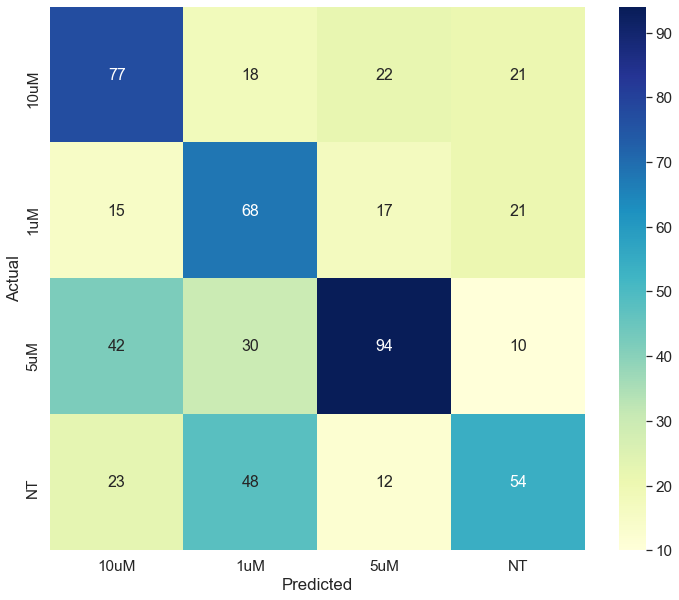

In [44]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(true_label, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

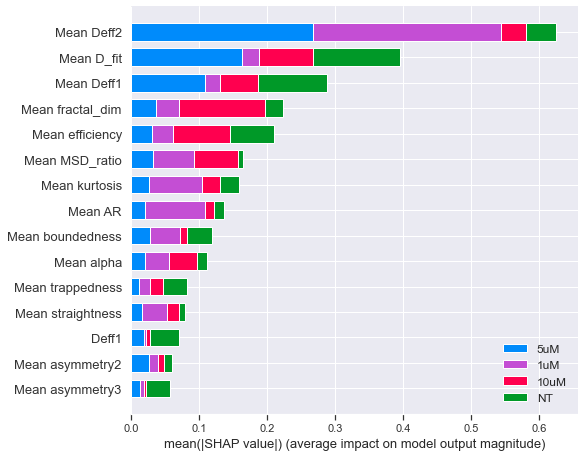

In [45]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[feature_list])
# c_NT = '#E69F00'
# c_HYase = '#56B4E9'
# c_ChABC = '#009E73'

# colors = [c_NT, c_HYase, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
# cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[feature_list], class_names=np.array(class_names), max_display=15, title='Total SHAP Values')#, color=cmap)

In [43]:
print(normal_acc.mean())
print(fillna_acc.mean())
print(dropna_acc.mean())
print(impute_knn_acc.mean())
print(impute_iterative_acc.mean())

0.5035108153078203
0.4685097893503301
0.5364678899082569
0.5039329742669061
0.49355265610438026


In [44]:
num_iters = 25

normal_acc = np.zeros(num_iters)
fillna_acc = np.zeros(num_iters)
dropna_acc = np.zeros(num_iters)
impute_knn_acc= np.zeros(num_iters)
impute_iterative_acc = np.zeros(num_iters)

for i in range(num_iters):
    dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm_7day, True, False, target)
    booster, acc, true_label, preds = predxgboost.train(param_7day, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=500, verbose=False)
    normal_acc[i] = acc
    fillna_acc[i] = get_fillna_scores(ecm_7day, 'dosage', param_7day, 1000, 0)
    dropna_acc[i] = get_dropna_scores(ecm_7day, 'dosage', param_7day, 200)
    impute_knn_acc[i] = get_impute_knn_scores(ecm_7day, 'dosage', param_7day, 1000)
    impute_iterative_acc[i] = get_impute_iterative_scores(ecm_7day, 'dosage', param_7day, 200)

Ratio before data balance (NT:5uM:50nM:1uM) = 3183:1485:2432:3700
Ratio after balance (NT:5uM:50nM:1uM) = 1485:1485:1485:1485
Accuracy: 0.47194719471947194
Ratio before data balance (NT:5uM:50nM:1uM) = 3183:1485:2432:3700
Ratio after balance (NT:5uM:50nM:1uM) = 1485:1485:1485:1485
Accuracy: 0.6369747899159663
accuracy is 0.6369747899159663
Ratio before data balance (NT:5uM:50nM:1uM) = 683:134:138:253
Ratio after balance (NT:5uM:50nM:1uM) = 134:134:134:134
Accuracy: 0.4426229508196721
Ratio before data balance (NT:5uM:50nM:1uM) = 3183:1485:2432:3700
Ratio after balance (NT:5uM:50nM:1uM) = 1485:1485:1485:1485
Accuracy: 0.46888567293777134
Ratio before data balance (NT:5uM:50nM:1uM) = 3183:1485:2432:3700
Ratio after balance (NT:5uM:50nM:1uM) = 1485:1485:1485:1485
Accuracy: 0.5525876460767947
Ratio before data balance (NT:5uM:50nM:1uM) = 3183:1485:2432:3700
Ratio after balance (NT:5uM:50nM:1uM) = 1485:1485:1485:1485
Accuracy: 0.49413735343383586
Ratio before data balance (NT:5uM:50nM:1uM) 

In [13]:
ecm_7day[target] = ecm_7day[target].replace({'50nM': 'rot', '5uM': 'rot', '1uM': 'rot' , '10uM': 'rot', 'NT': 'NC'})


dtrain, dtest, dval, X_train, X_test, y_train, y_test, le = full_preprocess(ecm_7day, True, False, target)
booster, acc, true_label, preds = predxgboost.train(param_7day, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=500, verbose=False)


Ratio before data balance (rot:NC) = 9813:2772
Ratio after balance (rot:NC) = 2772:2772
Accuracy: 0.6586270871985158


In [54]:
class_names = le.classes_
class_results = classification_report(true_label, preds, digits=2, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

          NC       0.81      0.78      0.80       315
         rot       0.78      0.80      0.79       301

    accuracy                           0.79       616
   macro avg       0.79      0.79      0.79       616
weighted avg       0.79      0.79      0.79       616



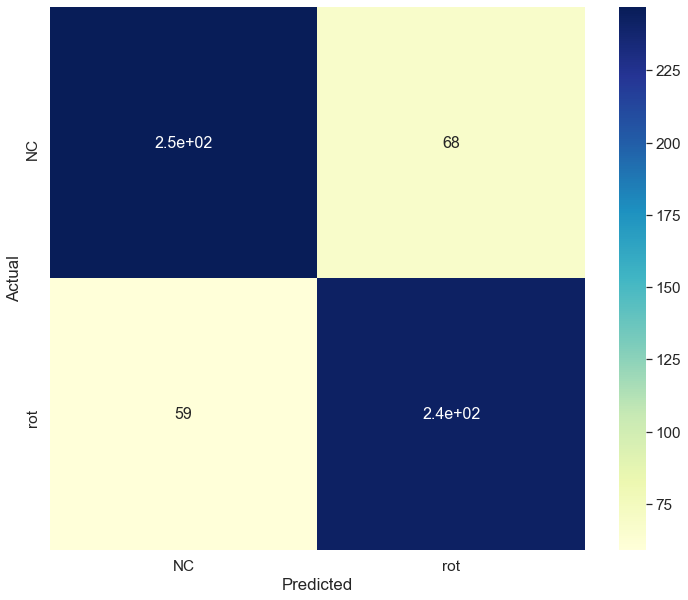

In [55]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(true_label, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

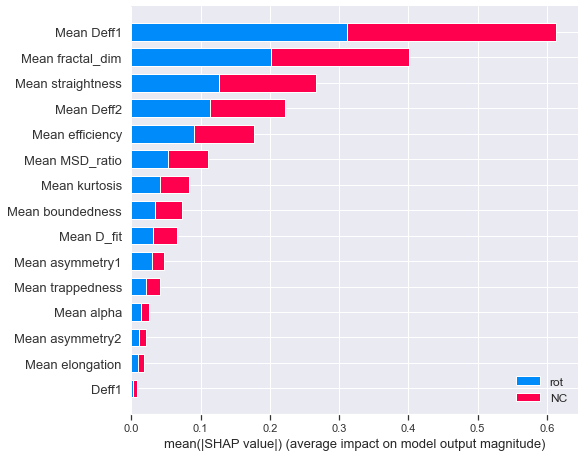

In [56]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[feature_list])
# c_NT = '#E69F00'
# c_HYase = '#56B4E9'
# c_ChABC = '#009E73'

# colors = [c_NT, c_HYase, c_ChABC]
#class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
# cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[feature_list], class_names=np.array(class_names), max_display=15, title='Total SHAP Values')#, color=cmap)

In [45]:
print(normal_acc.mean())
print(fillna_acc.mean())
print(dropna_acc.mean())
print(impute_knn_acc.mean())
print(impute_iterative_acc.mean())

0.5259776297761112
0.5585855436459535
0.5493138588435277
0.5285773673344982
0.5349065152660667
